### Updated for the latest dataset on 15th April,2021

In [1]:
# import the necessary libraries
import numpy as np 
import pandas as pd 
import os
from xml.etree import ElementTree

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# Visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pycountry
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
!pip install chart_studio
import chart_studio.plotly as py
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
#py.init_notebook_mode(connected=True)

#Geographical Plotting
import folium
from folium import Choropleth, Circle, Marker
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster

#Racing Bar Chart
!pip install bar_chart_race
import bar_chart_race as bcr
from IPython.display import HTML

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = 8, 5
plt.style.use("fivethirtyeight")# for pretty graphs

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Disable warnings 
import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 64 kB 701 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


     |████████████████████████████████| 156 kB 1.2 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
/kaggle/input/covid19-clinical-trials-dataset/COVID clinical trials.csv
/kaggle/input/covid19-clinical-trials-dataset/COVID-19 CLinical trials studies/COVID-19 CLinical trials studies/NCT04380961.xml
/kaggle/input/covid19-clinical-trials-dataset/COVID-19 CLinical trials studies/COVID-19 CLinical trials studies/NCT04333849.xml
/kaggle/input/covid19-clinical-trials-dataset/COVID-19 CLinical trials studies/COVID-19 CLinical trials studies/NCT04322487.xml
/kaggle/input/covid19-clinical-trials-dataset/COVID-19 CLinical trials studies/COVID-19 CLinical trials studies/NCT04363502.xml
/kaggle/input/covid19-clinical-trials-dataset/COVID-19 CLinical trials studies/COVID-19 CLinical trials studies/NCT04820257.xml
/kaggle/input/covid19-clinical-trials-dataset/COVID-19 CLinical trials studies/COVID-19 CLinical trials studies/NCT04558463.xml


In [2]:
list_of_files=os.listdir('../input/covid19-clinical-trials-dataset/COVID-19 CLinical trials studies/COVID-19 CLinical trials studies')
print('Total Researches going on: ',len(list_of_files))

Total Researches going on:  5783


# Clinical Terminology

Before jumping into the dataset, lets look at some basic definitions of the common clinical trial terminologies:

![](https://miro.medium.com/max/1400/1*gi_w8mUa3UmZFu86uOILBg.png)

For more information on Clinical Trials related glossary, refer to [this](https://clinicaltrials.gov/ct2/about-studies/glossary) and [this](https://medium.com/@gauravkantgoel/clinical-trials-glossary-6e1b4dc01e0d)

# Converting XML files into a Pandas Dataframe

Unhide the code to see how we can load the XML files data into a Pandas Dataframe

In [3]:
path = '../input/covid19-clinical-trials-dataset/COVID-19 CLinical trials studies/COVID-19 CLinical trials studies/'

# Read in data

df_covid = pd.DataFrame()
df = pd.DataFrame()
i=0
list_keywords=[]

for file in list_of_files:
    file_path=path+file
    #print('Processing....'+file_path)
    tree = ElementTree.parse(file_path)
    root = tree.getroot()

    trial = {}

    trial['id'] = root.find('id_info').find('nct_id').text
    trial['overall_status'] = root.find('overall_status').text
    trial['study_type'] = root.find('study_type').text
    
    if root.find('start_date') != None:
        trial['start_date'] = root.find('start_date').text
    else:
         trial['start_date'] = ''
        
    if root.find('enrollment') != None:
        trial['enrollment'] = root.find('enrollment').text
    else:
         trial['enrollment'] = ''

    trial['condition'] = root.find('condition').text.upper().replace('CORONAVIRUS INFECTIONS','CORONAVIRUS INFECTION').replace('CORONA VIRUS INFECTION','CORONAVIRUS INFECTION').replace('SARS-COV-2','SARS-COV2').replace('SARS-COV 2','SARS-COV2').replace('COVID-19','COVID').replace('COVID19','COVID').replace('COVID 19','COVID')
    if root.find('location_countries') != None:
        trial['location_countries'] = root.find('location_countries').find('country').text.upper()
    else:
        trial['location_countries'] = ''
        
    if root.find('intervention') != None:
        trial['intervention'] = root.find('intervention').find('intervention_name').text.upper()
    else:
        trial['intervention'] = ''
        
    #trial['description'] = root.find('brief_summary')[0].text
    for entry in root.findall('keyword'):
        list_keywords.append(entry.text)

    if root.find('official_title') == None:
        trial['title'] = root.find('brief_title').text
    else:
        trial['title'] = root.find('official_title').text

    date_string = root.find('required_header').find('download_date').text
    trial['date_processed'] = date_string.replace('ClinicalTrials.gov processed this data on ', '')
    
    trial['sponsors'] = root.find('sponsors').find('lead_sponsor').find('agency').text
    
    
    df  = pd.DataFrame(trial,index=[i])
    i=i+1
    
    df_covid = pd.concat([df_covid, df])
    

# View Total Studies and Attribute Names for each Study

In [4]:
df_covid.shape

(5783, 11)

In [5]:
df_covid.head()

,id,overall_status,study_type,start_date,enrollment,condition,location_countries,intervention,title,date_processed,sponsors
0,NCT04380961,Recruiting,Interventional,"April 24, 2020",111,CRITICAL CONFIRMED CORONAVIRUS DISEASE (COVID)-19,UNITED STATES,SIRUKUMAB,"Phase 2, Randomized, Double-blind, Placebo-con...","April 14, 2021","Janssen Pharmaceutica N.V., Belgium"
1,NCT04333849,Completed,Observational,"March 25, 2020",132,CORONAVIRUS,FRANCE,,Telephony Or Videophony for Isolated elDerly i...,"April 14, 2021","University Hospital, Angers"
2,NCT04322487,Recruiting,Observational,"April 8, 2020",100,CORONAVIRUS,ITALY,LUNG ULTRASOUND,Proposal for International Standardization of ...,"April 14, 2021",Catholic University of the Sacred Heart
3,NCT04363502,Recruiting,Interventional,"May 7, 2020",30,COVID,UNITED STATES,CLAZAKIZUMAB,A Randomized Placebo-controlled Safety and Dos...,"April 14, 2021",Johns Hopkins University
4,NCT04820257,Not yet recruiting,Interventional,March 2021,80,"COPD, CHRONIC OBSTRUCTIVE PULMONARY DISEASE",SWEDEN,HOME BASED EXERCISE,Home-based Pulmonary Rehabilitation for COPD P...,"April 14, 2021",Karolinska Institutet


# Overall status of studies

Overall status of the studies can be either of the following:

-   **Not yet recruiting:**  The study has not started recruiting participants.
-   **Recruiting:**  The study is currently recruiting participants.
-   **Enrolling by invitation:**  The study is selecting its participants from a population, or group of people, decided on by the researchers in advance. These studies are not open to everyone who meets the eligibility criteria but only to people in that particular population, who are specifically invited to participate.
-   **Active, not recruiting:**  The study is ongoing, and participants are receiving an intervention or being examined, but potential participants are not currently being recruited or enrolled.
-   **Suspended:**  The study has stopped early but may start again.
-   **Terminated:**  The study has stopped early and will not start again. Participants are no longer being examined or treated.
-   **Completed:**  The study has ended normally, and participants are no longer being examined or treated (that is, the last participant's last visit has occurred).
-   **Withdrawn:**  The study stopped early, before enrolling its first participant.
-   **Unknown:**  A study on ClinicalTrials.gov whose last known status was recruiting; not yet recruiting; or active, not recruiting but that has passed its completion date, and the status has not been  last verified  within the past 2 years.

In [6]:


df_covid['overall_status'].value_counts().sort_values(ascending=True).iplot(kind='barh',xTitle='Count',color='red')

# Study Types

Describes the nature of a clinical study. Study types include :

### Interventional studies (also called clinical trials),

A type of clinical study in which participants are assigned to groups that receive one or more intervention/treatment (or no intervention) so that researchers can evaluate the effects of the interventions on biomedical or health-related outcomes. The assignments are determined by the study's protocol. Participants may receive diagnostic, therapeutic, or other types of interventions.


### Observational studies (including patient registries), 

A type of clinical study in which participants are identified as belonging to study groups and are assessed for biomedical or health outcomes. Participants may receive diagnostic, therapeutic, or other types of interventions, but the investigator does not assign participants to a specific interventions/treatment.
A patient registry is a type of observational study.

### Expanded access.

A way for patients with serious diseases or conditions who cannot participate in a clinical trial to gain access to a medical product that has not been approved by the U.S. Food and Drug Administration (FDA). Also called compassionate use. There are different expanded access types.

In [7]:
labels = df_covid['study_type'].value_counts().index
values = df_covid['study_type'].value_counts().values
fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label+percent',
                             insidetextorientation='radial')])
fig.show()

# Interventions given

Intervention refers to the medicinal product (e.g drug, device, vaccine, placebo etc) given to the patients in a study. Let’s see the top five interventions given in these studies.

In [8]:
interventional_studies = df_covid[df_covid['study_type']=='Interventional']
top_interventions = interventional_studies['intervention'].value_counts().sort_values(ascending=True)[-5:]
top_interventions.iplot(kind='barh', title='Interventions',color='green')

## Which Countries are conducting Interventional Trials?

In [9]:
# Top 10 Countries
countries = interventional_studies[interventional_studies['location_countries']!='']
country = countries['location_countries'].value_counts().sort_values(ascending=True)[-15:]
country.iplot(kind='barh', title='Country')

## Lead Sponsors for studies

In [10]:
lead_sponsors = interventional_studies['sponsors'].value_counts().sort_values(ascending=True)[:10]
lead_sponsors.iplot(kind='bar', title='Lead Sponsors')

# How large are Interventional Trials?
The size of a trial depend upon the number of patients enrolled.

In [11]:
# Convert to numeric
interventional_studies['enrollment'] = interventional_studies['enrollment'].astype(int)
# Remove the trials with recruitment status withdrawn and terminated
enrollment = interventional_studies.loc[
 (interventional_studies['overall_status'] != 'Withdrawn') & (interventional_studies['overall_status'] != 'Terminated')]
bins = [-1, 20, 40, 60, 100, 200, 400, 600, 1000]
group_names = ['< 20', '21-40', '41-60', '61-100', '101-200', '201-400', '401-600', '>600']
categories = pd.cut(enrollment['enrollment'], bins, labels=group_names)
# Add categories as column in dataframe
enrollment['Category'] = categories
# View value counts
enrollment_counts = enrollment['Category'].value_counts().sort_index(ascending=True)
enrollment_counts

< 20       262
21-40      404
41-60      369
61-100     446
101-200    532
201-400    403
401-600    207
>600       175
Name: Category, dtype: int64

In [12]:
enrollment_counts.iplot(kind='bar', title='Size of Interventional Trials')

# Clinical trials Phases

![](https://lupustrials.org/wp-content/uploads/2019/01/clinical-trial-phases-graphic.jpg)
source: https://lupustrials.org/about-trials/phases-of-a-trial/

In [13]:
trials = pd.read_csv('../input/covid19-clinical-trials-dataset/COVID clinical trials.csv')
trials.head()

,Rank,NCT Number,Title,Acronym,Status,Study Results,Conditions,Interventions,Outcome Measures,Sponsor/Collaborators,...,Other IDs,Start Date,Primary Completion Date,Completion Date,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents,URL
0,1,NCT04785898,Diagnostic Performance of the ID Now™ COVID-19...,COVID-IDNow,"Active, not recruiting",No Results Available,Covid19,Diagnostic Test: ID Now™ COVID-19 Screening Test,Evaluate the diagnostic performance of the ID ...,Groupe Hospitalier Paris Saint Joseph,...,COVID-IDNow,"November 9, 2020","December 22, 2020","April 30, 2021","March 8, 2021",NaN,"March 8, 2021","Groupe Hospitalier Paris Saint-Joseph, Paris, ...",NaN,https://ClinicalTrials.gov/show/NCT04785898
1,2,NCT04595136,Study to Evaluate the Efficacy of COVID19-0001...,COVID-19,Not yet recruiting,No Results Available,SARS-CoV-2 Infection,Drug: Drug COVID19-0001-USR|Drug: normal saline,Change on viral load results from baseline aft...,United Medical Specialties,...,COVID19-0001-USR,"November 2, 2020","December 15, 2020","January 29, 2021","October 20, 2020",NaN,"October 20, 2020","Cimedical, Barranquilla, Atlantico, Colombia",NaN,https://ClinicalTrials.gov/show/NCT04595136
2,3,NCT04395482,Lung CT Scan Analysis of SARS-CoV2 Induced Lun...,TAC-COVID19,Recruiting,No Results Available,covid19,Other: Lung CT scan analysis in COVID-19 patients,A qualitative analysis of parenchymal lung dam...,University of Milano Bicocca,...,TAC-COVID19,"May 7, 2020","June 15, 2021","June 15, 2021","May 20, 2020",NaN,"November 9, 2020","Ospedale Papa Giovanni XXIII, Bergamo, Italy|P...",NaN,https://ClinicalTrials.gov/show/NCT04395482
3,4,NCT04416061,The Role of a Private Hospital in Hong Kong Am...,COVID-19,"Active, not recruiting",No Results Available,COVID,Diagnostic Test: COVID 19 Diagnostic Test,Proportion of asymptomatic subjects|Proportion...,Hong Kong Sanatorium & Hospital,...,RC-2020-08,"May 25, 2020","July 31, 2020","August 31, 2020","June 4, 2020",NaN,"June 4, 2020","Hong Kong Sanatorium & Hospital, Hong Kong, Ho...",NaN,https://ClinicalTrials.gov/show/NCT04416061
4,5,NCT04395924,Maternal-foetal Transmission of SARS-Cov-2,TMF-COVID-19,Recruiting,No Results Available,Maternal Fetal Infection Transmission|COVID-19...,Diagnostic Test: Diagnosis of SARS-Cov2 by RT-...,COVID-19 by positive PCR in cord blood and / o...,Centre Hospitalier Régional d'Orléans|Centre d...,...,CHRO-2020-10,"May 5, 2020",May 2021,May 2021,"May 20, 2020",NaN,"June 4, 2020","CHR Orléans, Orléans, France",NaN,https://ClinicalTrials.gov/show/NCT04395924


In [14]:
labels = trials['Phases'].value_counts().drop('Not Applicable').index
values = trials['Phases'].value_counts().drop('Not Applicable').values
fig = go.Figure(data=[go.Pie(labels=labels, values=values, textinfo='label',
                             insidetextorientation='radial')])
fig.show()

Maximum trials are in Phase 2. However, some trials have also reached Phase 4. Let's now create a word cloud of the title used in Phase 4 trials to see which words dominate.


In [15]:
# text preprocessing helper functions

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    #remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(tokenized_text)
    return combined_text

In [16]:
# Applying the cleaning function to the dataset
phase_4_trials = trials[trials['Phases']=='Phase 4']['Title'].apply(str).apply(lambda x: text_preprocessing(x))

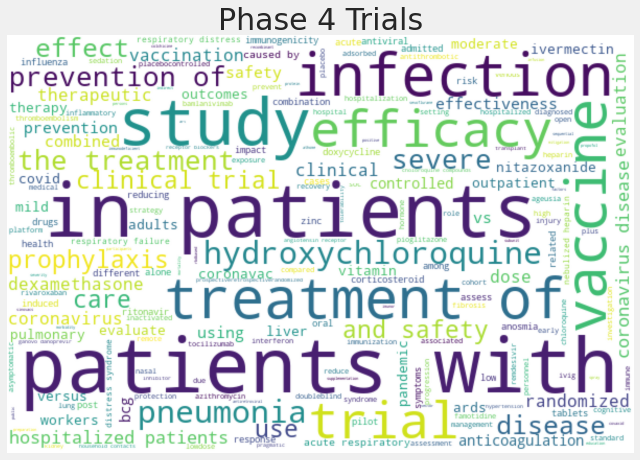

In [17]:
from wordcloud import WordCloud
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(phase_4_trials))

plt.figure(figsize=(10, 16))
plt.title('Phase 4 Trials',fontsize=30);
plt.imshow(wordcloud1, interpolation="gaussian")
plt.axis("off")
plt.show()

Disclaimer: This article is meant only for the purpose of explaining basic techniques of data analysis. This is not meant to provide any medical advice of any kind for COVID-19. Please take all precautions and stay safe!